In [ ]:
# Part A Task 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df = pd.read_csv('Airbnb_data.csv')
df.head()

df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

host_response_rate        18299
review_scores_rating      16722
first_review              15864
last_review               15827
thumbnail_url              8216
neighbourhood              6872
zipcode                     968
bathrooms                   200
host_identity_verified      188
host_has_profile_pic        188
host_since                  188
beds                        131
bedrooms                     91
description                   0
city                          0
cleaning_fee                  0
cancellation_policy           0
accommodates                  0
bed_type                      0
room_type                     0
amenities                     0
id                            0
log_price                     0
property_type                 0
instant_bookable              0
longitude                     0
latitude                      0
number_of_reviews             0
name                          0
dtype: int64

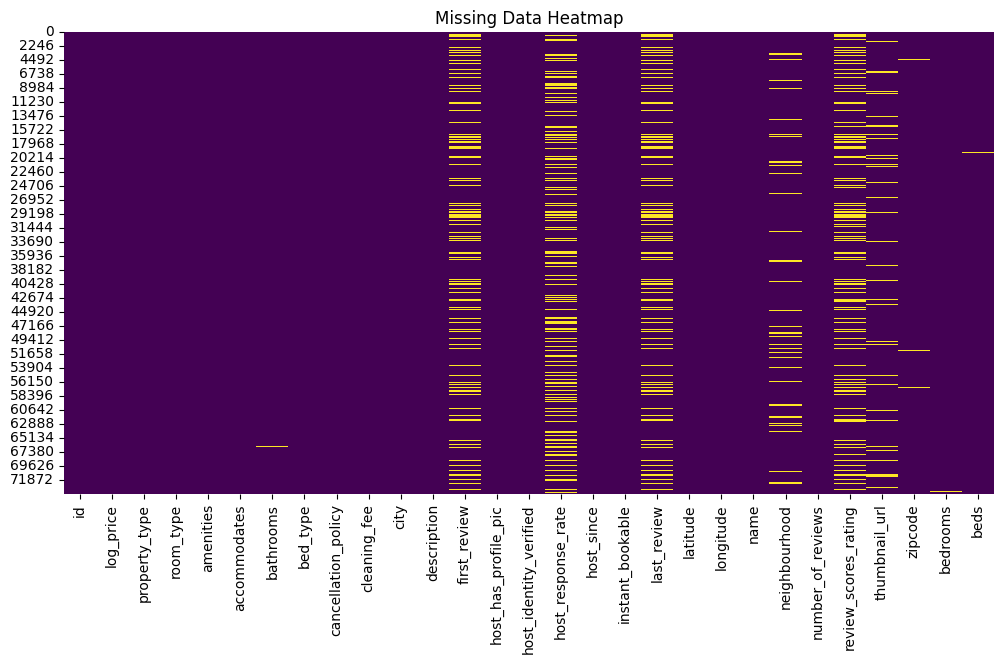

In [ ]:
# Visualize missing data
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

# Drop columns with too many missing values (threshold can be tuned)
threshold = 0.4  # drop if more than 40% missing
df = df[df.columns[df.isnull().mean() < threshold]]

# Fill remaining numeric with median and categorical with mode
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

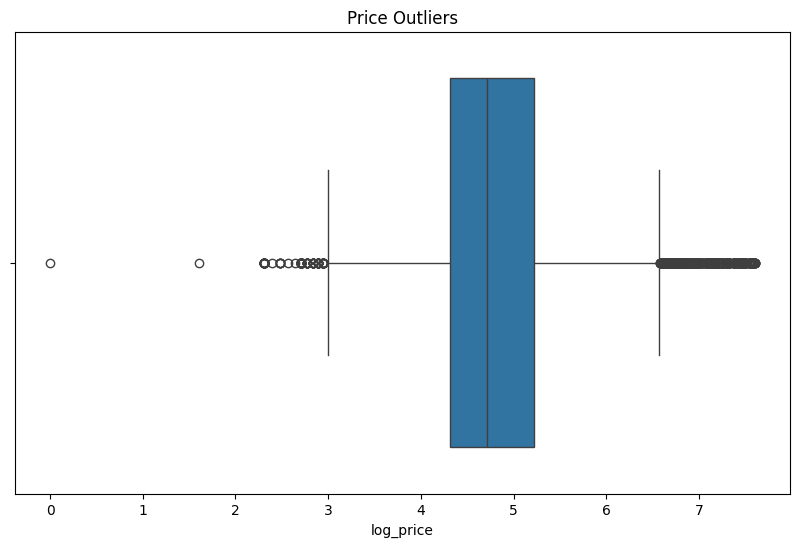

In [ ]:
# Outlier Detection and Handling
# Boxplot for key numerical variables
plt.figure(figsize=(10,6))
sns.boxplot(x=df['log_price'])
plt.title("Price Outliers")
plt.show()

# Remove extreme price outliers
df = df[df['log_price'] < df['log_price'].quantile(0.99)]

In [ ]:
# Feature Engineering

# Log transformation to normalize price
df['log_price'] = np.log1p(df['log_price'])

# Feature: number of amenities (assumes amenities is a string)
if 'amenities' in df.columns:
    df['num_amenities'] = df['amenities'].apply(lambda x: len(str(x).split(',')))

# Host listing count: proxy for host experience
if 'host_total_listings_count' in df.columns:
    df['host_activity'] = df['host_total_listings_count']

# Drop unnecessary columns (IDs, names, etc.)
df = df.drop(['id', 'name', 'description'], axis=1, errors='ignore')

In [ ]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 1. Log-transform the target
df['log_price'] = np.log1p(df['log_price'])

# 2. Separate features and target
X_raw = df.drop('log_price', axis=1)
y = df['log_price']

# 3. Identify column types
numeric_cols =X_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols =X_raw.select_dtypes(include=['object', 'category']).columns.tolist()

# 4. Create a preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Apply the transformation
X = preprocessor.fit_transform(X_raw)

In [ ]:
# Data Splitting

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Part A Task 2

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 1: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 2: Train-test-validation split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 60/20/20

# Step 3: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Step 4: Evaluate on validation set
y_val_pred = lr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("Linear Regression - Validation RMSE:", rmse)
print("Linear Regression - Validation R²:", r2)

Linear Regression - Validation RMSE: 0.028806616456257966
Linear Regression - Validation R²: 0.6020723229245091


In [ ]:
# Part A Task 3

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_test_pred = lr.predict(X_test)

# Calculate evaluation metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print("📊 Model Evaluation on Test Set:")
print(f"✅ RMSE: {rmse_test:.2f}")
print(f"✅ MAE:  {mae_test:.2f}")
print(f"✅ R²:   {r2_test:.2f}")

📊 Model Evaluation on Test Set:
✅ RMSE: 0.03
✅ MAE:  0.02
✅ R²:   0.63
